<a href="https://colab.research.google.com/github/SanghunOh/study_machinglearning/blob/main/codes/sanghunoh/reports/Term_2_Finetuning_MPIE_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Connect Drive

In [1]:
path_root = '/content/drive/MyDrive/datas/'

# 작업 경로 설정
import os
os.chdir(path_root)
!ls

matlab_iris_shuffle.mat
results_Finetuning_label_1_202205301519.pickle
results_Finetuning_label_2_202205301519.pickle
results_Finetuning_label_4_202205301519.pickle


In [34]:
# config param
file_prefix = 'results_Finetuning_label_'  # file name
save_file = True  # save graph, csv 

In [3]:
import glob

filename_list = []
for file_name in glob.glob(f"./{file_prefix}*.pickle"):
    filename_list.append(file_name)
filename_list

['./results_Finetuning_label_1_202205301519.pickle',
 './results_Finetuning_label_2_202205301519.pickle',
 './results_Finetuning_label_4_202205301519.pickle']

##Load Trained Model

In [4]:
import pickle
results_list = list()
for filename in filename_list:
  with open(filename, 'rb') as f:
    results_list.append(pickle.load(f))
len(results_list)   # model, history, execution_time, _params

3

##create DataFrame with concate params from results

###결과값을 순서 맞게 나열하기
순서 : params + history values + model layers + training time + history params


In [35]:
import numpy as np
def resultToValueslist(model, history, training_time, params):
  model_layer_depth = [len(model.layers)]
  history_values = list(np.array(list(history.history.values()))[:,-1])
  history_params = list(history.params.values())
  _training_time = [training_time]
  params_values = list(params.values())
  _value_list = params_values + history_values + model_layer_depth + _training_time + history_params
  return _value_list
# value_list

###학습결과값을 DataFrame으로 만들기

In [36]:
# merge column epochs (epochs 컬럼 2개임)
import pandas as pd

def mergeColumnWithepochs(dataframe):
  # dataframe = _dataframe.copy()
  _epochs_temp = dataframe['epochs']
  _epochs_temp = _epochs_temp.iloc[:,0]
  dataframe.drop(labels=['epochs', 'verbose'], axis=1, inplace=True)
  _result_df = pd.concat([dataframe, _epochs_temp],axis=1)
  return _result_df

In [37]:
def valueslistToDataFrame(_result_per_label_list):
  _results_list = list()
  for _results in _result_per_label_list:
    _model, _history, _training_time, _params = _results[0], _results[1], _results[2], _results[3]
    # print(f'Training Time : {_training_time:.3f} sec')
    _results_list.append(resultToValueslist(_model, _history, _training_time, _params))
  _column_name = list(_params.keys())+list(_history.history.keys())+['model_layer_depth','training_time']+list(_history.params.keys())

  # print(f'valueslistToDataFrame : {len(_results_list)}, column_name: {_column_name}')
  _result_df = pd.DataFrame(_results_list, columns=_column_name)
  _result_df = mergeColumnWithepochs(_result_df)
  return _result_df

###label_class 별로 DataFrame을 list 담기

In [38]:
import pandas as pd

results_df_list = list()
for result_per_label_list in results_list:
  results_df_list.append(valueslistToDataFrame(result_per_label_list))

In [39]:
# results_df_list[0]

##Evaluation

###Per Label class

In [40]:
evaluation_columns = ['loss', 'val_loss', 'accuracy', 'val_accuracy']

In [41]:
def sortEvaluationColumns(_results_df):
  _evaluation_df = _results_df.sort_values(evaluation_columns, ascending = [True, False, True, False])
  print(len(_evaluation_df.columns), _evaluation_df.columns)
  return _evaluation_df

In [42]:
evaluation_df_list = list()
for results_df in results_df_list:
  evaluation_df_list.append(sortEvaluationColumns(results_df))
# evaluation_df


13 Index(['_learning_rate', '_logits_flag', 'fine_tune_at', '_class_cnt',
       'label_class', 'loss', 'accuracy', 'val_loss', 'val_accuracy',
       'model_layer_depth', 'training_time', 'steps', 'epochs'],
      dtype='object')
13 Index(['_learning_rate', '_logits_flag', 'fine_tune_at', '_class_cnt',
       'label_class', 'loss', 'accuracy', 'val_loss', 'val_accuracy',
       'model_layer_depth', 'training_time', 'steps', 'epochs'],
      dtype='object')
13 Index(['_learning_rate', '_logits_flag', 'fine_tune_at', '_class_cnt',
       'label_class', 'loss', 'accuracy', 'val_loss', 'val_accuracy',
       'model_layer_depth', 'training_time', 'steps', 'epochs'],
      dtype='object')


###draw evaluation

In [56]:
import matplotlib.pyplot as plt

def drawEvaluation(_evaluation_df, _save_file=False, _label=None):
  plt.rcParams["figure.figsize"] = (15, 5)

  plt.subplot(121)
  _evaluation_df[['loss', 'val_loss']].T.plot(ax=plt.gca())
  plt.grid(axis='y')
  plt.title('loss rate')
  # plt.xticks(rotation=20)

  plt.subplot(122)
  _evaluation_df[['accuracy', 'val_accuracy']].T.plot(ax=plt.gca())
  plt.grid(axis='y')
  # plt.xticks(rotation=20)
  plt.title('accuracy rate')

  _label_class = _label
  if not _label:
    _label_class = _evaluation_df.loc[0,'label_class']
  
  plt.suptitle(f'label_class : {_label_class}')
  if _save_file:
    _file_name = file_prefix + str(_label_class) + '.png'
    plt.savefig(_file_name)
  plt.show()


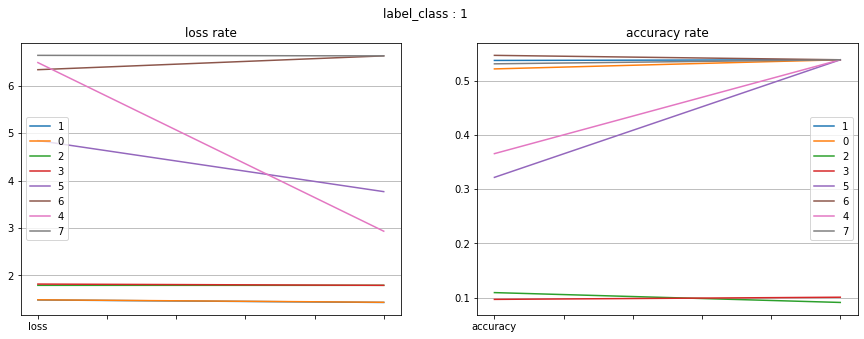

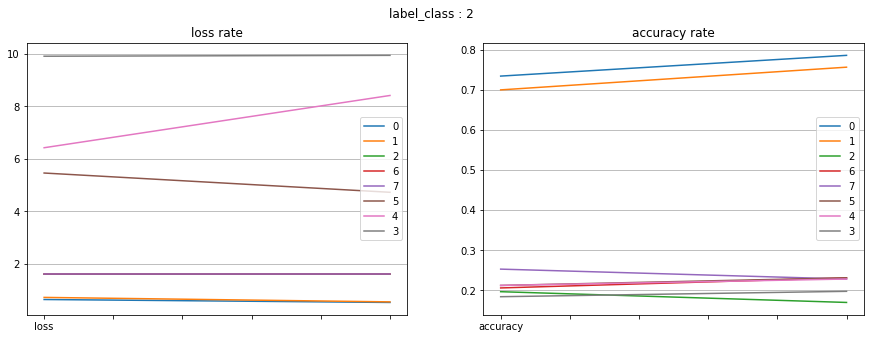

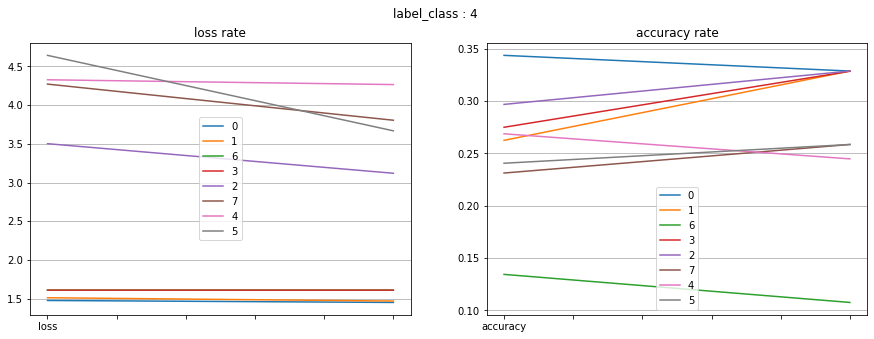

In [57]:
for evaluation_df in evaluation_df_list:
  drawEvaluation(evaluation_df, save_file)


###성능 영향 준 Parameters

In [45]:
def getParametersByPerformance(_evaluation_df, _save_file=False, _label=None):
  _label_class = _label
  if not _label:
    _label_class = _evaluation_df.loc[0,'label_class']

  columns_mask_str = _evaluation_df.columns.map(lambda x: True if (x not in evaluation_columns) else False )
  # print(columns_mask_str, len(list(columns_mask_str)))
  performance_df = _evaluation_df.loc[:,columns_mask_str].value_counts().reset_index()
  performance_df.drop(labels=0, axis=1, inplace=True)

  _measure_columns = list()
  for column in performance_df.columns:
    if len(performance_df[column].unique()) > 1:
      _measure_columns.append(column)
  # print(_measure_columns)
  result_columns = evaluation_columns + _measure_columns
  _evaluation_df = _evaluation_df[result_columns]

  if _save_file:
    _file_name = file_prefix + str(_label_class) + '.csv'
    _evaluation_df.to_csv(_file_name)
  return _evaluation_df

In [46]:
performance_params_df_list = list()
for evaluation_df in evaluation_df_list:
  performance_params_df_list.append(getParametersByPerformance(evaluation_df, save_file))
# performance_params_df_list[-1]

In [47]:
performance_params_df_list[0]

,loss,val_loss,accuracy,val_accuracy,_learning_rate,_logits_flag,fine_tune_at,training_time
1,1.483597,1.431057,0.537500,0.538734,0.0001,True,0.1,331.581440
0,1.486658,1.434523,0.521875,0.538734,0.0001,True,0.0,330.882372
2,1.791759,1.791762,0.109375,0.091231,0.0001,False,0.0,350.204086
3,1.818051,1.791762,0.096875,0.100865,0.0001,False,0.1,332.425437
5,4.841646,3.765788,0.321875,0.538734,0.0100,True,0.1,332.228429
6,6.334481,6.625723,0.546875,0.538734,0.0100,False,0.0,339.015987
4,6.484625,2.931918,0.365625,0.538734,0.0100,True,0.0,329.790816
7,6.636695,6.625723,0.531250,0.538734,0.0100,False,0.1,354.919088


##Concate All Dataset for Performance

In [58]:
results_df_all = pd.concat(results_df_list).reset_index()
results_df_all.drop(labels='index', axis=1, inplace=True)
results_df_all

,_learning_rate,_logits_flag,fine_tune_at,_class_cnt,label_class,loss,accuracy,val_loss,val_accuracy,model_layer_depth,training_time,steps,epochs
0,0.0001,True,0.0,6,1,1.486658,0.521875,1.434523,0.538734,6,330.882372,5,10
1,0.0001,True,0.1,6,1,1.483597,0.537500,1.431057,0.538734,6,331.581440,5,10
2,0.0001,False,0.0,6,1,1.791759,0.109375,1.791762,0.091231,6,350.204086,5,10
3,0.0001,False,0.1,6,1,1.818051,0.096875,1.791762,0.100865,6,332.425437,5,10
4,0.0100,True,0.0,6,1,6.484625,0.365625,2.931918,0.538734,6,329.790816,5,10
5,0.0100,True,0.1,6,1,4.841646,0.321875,3.765788,0.538734,6,332.228429,5,10
6,0.0100,False,0.0,6,1,6.334481,0.546875,6.625723,0.538734,6,339.015987,5,10
7,0.0100,False,0.1,6,1,6.636695,0.531250,6.625723,0.538734,6,354.919088,5,10
8,0.0001,True,0.0,5,2,0.643135,0.734375,0.531110,0.786079,6,370.567495,5,10
9,0.0001,True,0.1,5,2,0.723346,0.700000,0.552715,0.756587,6,361.040153,5,10


In [59]:
evaluation_df_all = sortEvaluationColumns(results_df_all)
evaluation_df_all

13 Index(['_learning_rate', '_logits_flag', 'fine_tune_at', '_class_cnt',
       'label_class', 'loss', 'accuracy', 'val_loss', 'val_accuracy',
       'model_layer_depth', 'training_time', 'steps', 'epochs'],
      dtype='object')


,_learning_rate,_logits_flag,fine_tune_at,_class_cnt,label_class,loss,accuracy,val_loss,val_accuracy,model_layer_depth,training_time,steps,epochs
8,0.0001,True,0.0,5,2,0.643135,0.734375,0.531110,0.786079,6,370.567495,5,10
9,0.0001,True,0.1,5,2,0.723346,0.700000,0.552715,0.756587,6,361.040153,5,10
16,0.0001,True,0.0,5,4,1.475729,0.343750,1.450356,0.328746,6,369.427634,5,10
1,0.0001,True,0.1,6,1,1.483597,0.537500,1.431057,0.538734,6,331.581440,5,10
0,0.0001,True,0.0,6,1,1.486658,0.521875,1.434523,0.538734,6,330.882372,5,10
17,0.0001,True,0.1,5,4,1.511143,0.262500,1.468338,0.328746,6,369.904902,5,10
10,0.0001,False,0.0,5,2,1.606374,0.196875,1.609437,0.170075,6,365.136085,5,10
22,0.0100,False,0.0,5,4,1.609438,0.134375,1.609437,0.107550,6,359.632588,5,10
14,0.0100,False,0.0,5,2,1.609438,0.206250,1.609437,0.231420,6,373.057324,5,10
15,0.0100,False,0.1,5,2,1.609438,0.253125,1.609437,0.228470,6,362.883751,5,10


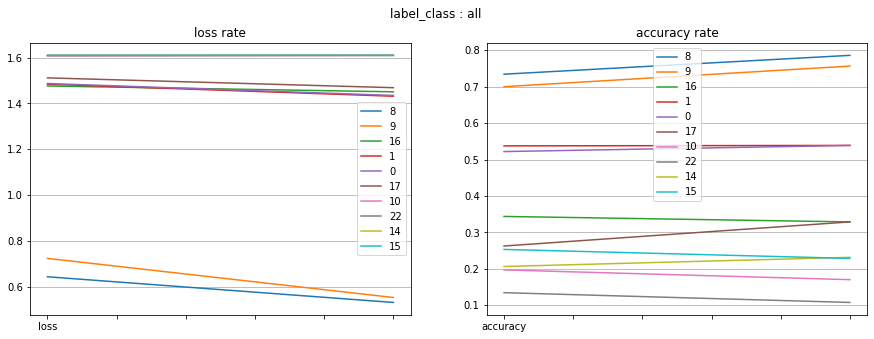

In [60]:
evaluation_df_all_rank = evaluation_df_all[:10]
drawEvaluation(evaluation_df_all_rank, save_file, _label='all')

In [61]:
getParametersByPerformance(evaluation_df_all_rank, save_file, _label='all')

,loss,val_loss,accuracy,val_accuracy,_learning_rate,_logits_flag,fine_tune_at,_class_cnt,label_class,training_time
8,0.643135,0.531110,0.734375,0.786079,0.0001,True,0.0,5,2,370.567495
9,0.723346,0.552715,0.700000,0.756587,0.0001,True,0.1,5,2,361.040153
16,1.475729,1.450356,0.343750,0.328746,0.0001,True,0.0,5,4,369.427634
1,1.483597,1.431057,0.537500,0.538734,0.0001,True,0.1,6,1,331.581440
0,1.486658,1.434523,0.521875,0.538734,0.0001,True,0.0,6,1,330.882372
17,1.511143,1.468338,0.262500,0.328746,0.0001,True,0.1,5,4,369.904902
10,1.606374,1.609437,0.196875,0.170075,0.0001,False,0.0,5,2,365.136085
22,1.609438,1.609437,0.134375,0.107550,0.0100,False,0.0,5,4,359.632588
14,1.609438,1.609437,0.206250,0.231420,0.0100,False,0.0,5,2,373.057324
15,1.609438,1.609437,0.253125,0.228470,0.0100,False,0.1,5,2,362.883751
